6.7 Analysis of etching sites in Cu3As NPs

In [1]:
import numpy as np
import pyvista as pv
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.csgraph import dijkstra
import matplotlib.pyplot as plt
from matplotlib.widgets import RangeSlider
import math

In [2]:
def load_curvature(file_path, verbose=False):
    with open(file_path, "r") as f:
        lines = f.readlines()
    
    # Find where the data starts (after "@1")
    start_index = next(i for i, line in enumerate(lines) if line.strip() == "@1") + 1
    
    # Read numeric data into numpy array
    curvature = np.array([float(line) for line in lines[start_index:] if line.strip()])

    if verbose:
        print(curvature.shape)
        print(curvature[:10])  # preview first 10 values

    return curvature

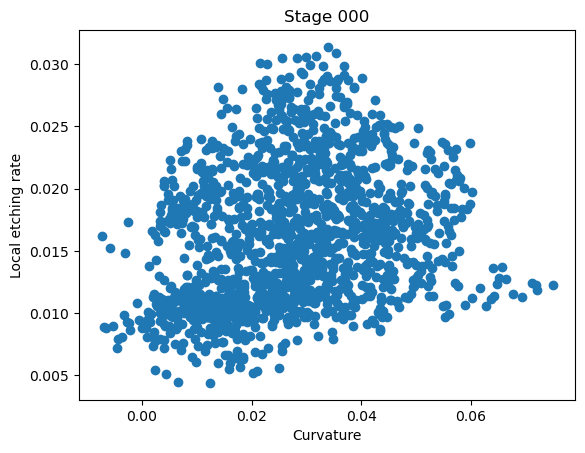

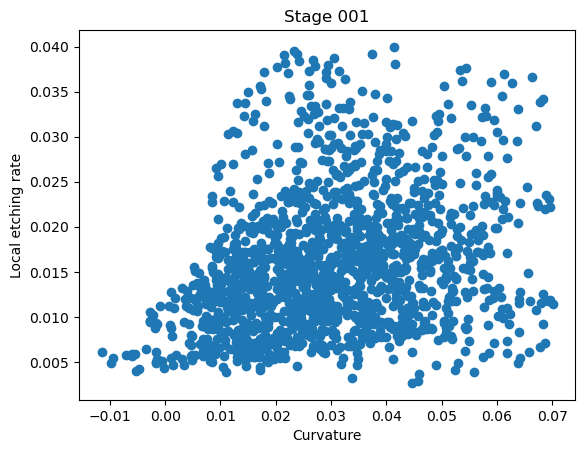

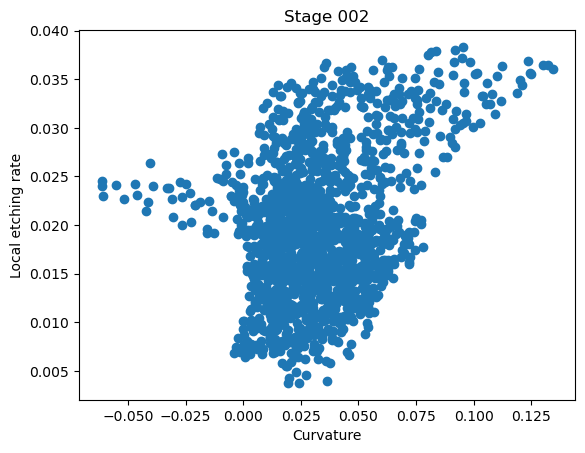

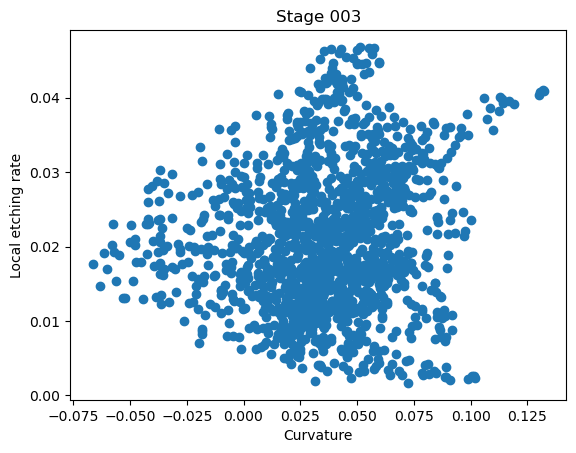

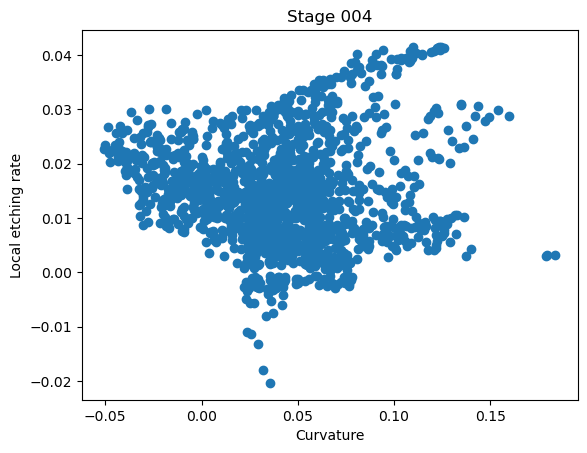

In [3]:
curvature_dir = "surface Cu3As/" 
etching_dir = "localEtchingRate_t_t+2/"

for i in range(5):
    curvature = load_curvature(curvature_dir+"00"+str(int(i))+".am") #Surface curvatures generated by Amira
    etching_rate = np.loadtxt(etching_dir+"00"+str(int(i))+".csv") #See 6.4 for calculting surface etching rates

    plt.figure()
    plt.scatter(curvature, etching_rate)
    plt.xlabel("Curvature")
    plt.ylabel("Local etching rate")
    plt.title("Stage "+"00"+str(int(i)))

In [4]:
#Optional visualization
mesh = pv.read("surface Cu3As/000.obj").triangulate() #Surface meshes generated by Amira

picked_origin = {"index": None}   # store the chosen vertex index

def callback(p):
    # Find closest vertex index to the picked 3D point
    i = np.argmin(np.linalg.norm(mesh.points - p, axis=1))
    picked_origin["index"] = i
    print(f"Picked vertex {i}, coords={mesh.points[i]}")
    # Highlight picked point
    plotter.add_points(mesh.points[i][None,:], color="red",
                       point_size=12, render_points_as_spheres=True)

plotter = pv.Plotter()
plotter.add_mesh(mesh, color="lightgray", opacity=0.6)
plotter.enable_point_picking(callback=callback,
                             show_message=True,
                             left_clicking=True)
plotter.show()

Widget(value='<iframe src="http://localhost:46821/index.html?ui=P_0x70c6fc3fd550_0&reconnect=auto" class="pyvi…

In [5]:
OBJ_PATH = "surface Cu3As/000.obj"
curvature = curvature.astype(float)  # your 1D array of length N (one per vertex)
etching_rate = etching_rate.astype(float)


# ---- Load mesh & sanity checks ----
mesh = pv.read(OBJ_PATH).triangulate()

# ---- Pick the origin vertex ----
# Option A: pick by index
# origin_index = 0
origin_index = np.argmax(etching_rate)

# Option B: or pick the vertex closest to a given 3D point (x0, y0, z0)
# origin_point = np.array([128, 256, 128], dtype=float)
# origin_index = np.argmin(np.linalg.norm(mesh.points - origin_point, axis=1))

# ---- Build edge-weighted graph from faces (weights = edge lengths) ----
def scatter_plot_with_dist(mesh, curvature, etching_rate, origin_index, dist_range=None, title=None, show_model=False):
    N = mesh.n_points
    faces = mesh.faces.reshape(-1, 4)
    if not np.all(faces[:, 0] == 3):
        mesh = mesh.triangulate()
        faces = mesh.faces.reshape(-1, 4)
    tri_idx = faces[:, 1:]  # (M,3) vertex indices
    
    # Collect undirected edges (i,j) with Euclidean length on the surface
    ii = []
    jj = []
    ww = []
    pts = mesh.points
    for a, b, c in tri_idx:
        for u, v in ((a, b), (b, c), (c, a)):
            if u > v: u, v = v, u  # undirected: store u < v
            ii.append(u); jj.append(v)
            ww.append(np.linalg.norm(pts[u] - pts[v]))
    
    # Deduplicate parallel edges by taking the smallest weight
    # (coo_matrix with duplicates sums; we take min by building both directions and then min)
    rows = np.array(ii + jj, dtype=int)
    cols = np.array(jj + ii, dtype=int)
    data_w = np.array(ww + ww, dtype=float)
    # If duplicates exist, keep the min weight:
    # We'll convert to CSR and then for each row keep the smallest edge to each col
    G = coo_matrix((data_w, (rows, cols)), shape=(N, N)).tocsr()
    G = G.minimum(G.transpose())  # ensure symmetry; keep minimum weights
    
    # ---- Dijkstra: geodesic distance from origin vertex to all vertices ----
    dist = dijkstra(G, directed=False, indices=origin_index)  # shape (N,)

    if dist_range:
        if len(dist_range)==2:
            dist_min, dist_max = dist_range
        elif len(dist_range)==1:
            dist_min = dist_range[0]
            dist_max = float(np.nanmax(dist))
        else:
            dist_min, dist_max = float(np.nanmin(dist)), float(np.nanmax(dist))
            print("Invalid input for dist_range ignored.")
    else:
        dist_min, dist_max = float(np.nanmin(dist)), float(np.nanmax(dist))

    # mask = np.ones_like(dist, dtype=bool)
    m = (dist >= dist_min) & (dist <= dist_max)
    
    # ---- 2D scatter: x = geodesic distance, y = your data ----
    fig, ax = plt.subplots(figsize=(8, 6))
    # plt.subplots_adjust(bottom=0.22)  # leave room for slider
    sc = ax.scatter(curvature[m], etching_rate[m], c=dist[m], cmap="nipy_spectral", s=6, vmin=float(np.nanmin(dist)), vmax=float(np.nanmax(dist)))
    cb = plt.colorbar(sc, label="Geodesic distance from origin")
    ax.set_xlabel("Curvature")
    ax.set_ylabel("Local etching rate")
    ax.set_xlim(curvature.min(), curvature.max())
    ax.set_ylim(etching_rate.min(), etching_rate.max())
    ax.grid(True, alpha=0.25)
    # count_text = ax.text(0.02, 0.98, f"points: {m.sum()}", transform=ax.transAxes,
    #                  ha="left", va="top", fontsize=9)
    # Slider axis (x-position, y-position, width, height)
    # ax_slider = plt.axes([0.12, 0.08, 0.76, 0.04])
    # rslider = RangeSlider(ax_slider, "Distance range", dist_min, dist_max, valinit=(dist_min, dist_max))
    # plt.title("Data vs. surface distance from origin")
    if title:
        ax.set_title(title)
    # plt.tight_layout()

    # def update_slider(vals):
    #     lo, hi = rslider.val
    #     m = (x >= lo) & (x <= hi)
    #     # update scatter data
    #     sc.set_offsets(np.c_[x[m], y[m]])
    #     sc.set_array(y[m])  # keep coloring by data values; or use x[m] to color by distance
    #     # (Optional) rescale axes to remaining points:
    #     if np.any(m):
    #         ax.set_ylim(np.nanmin(y[m]), np.nanmax(y[m]))
    #     count_text.set_text(f"points: {int(m.sum())}")
    #     fig.canvas.draw_idle()
    
    # rslider.on_changed(update_slider)
    plt.show()
    
    
    # (Optional) also visualize distance on the mesh to sanity-check the origin choice
    if show_model:
        mesh_dist = mesh.copy()
        mesh_dist["geo_dist"] = dist
        p = pv.Plotter()
        p.add_mesh(mesh_dist, scalars="geo_dist", cmap="nipy_spectral", show_scalar_bar=True, smooth_shading=True)
        p.add_points(mesh.points[origin_index][None, :], color="red", point_size=12, render_points_as_spheres=True)
        p.show()
    return dist

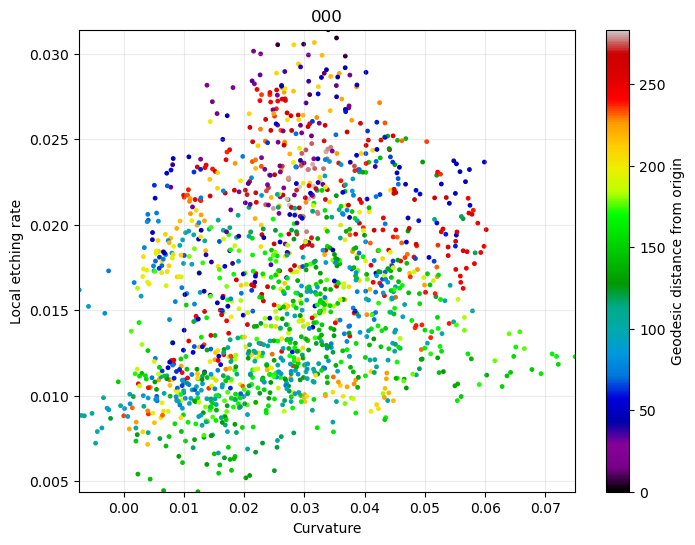

Widget(value='<iframe src="http://localhost:46821/index.html?ui=P_0x70c6d4188190_1&reconnect=auto" class="pyvi…

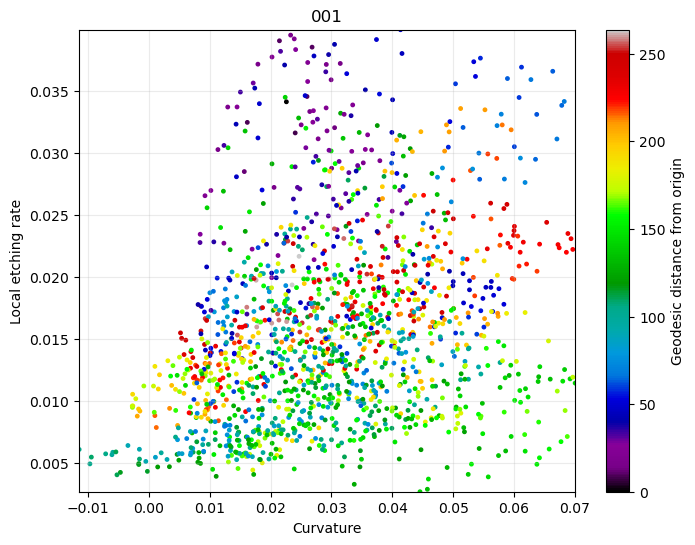

Widget(value='<iframe src="http://localhost:46821/index.html?ui=P_0x70c6d40fc050_2&reconnect=auto" class="pyvi…

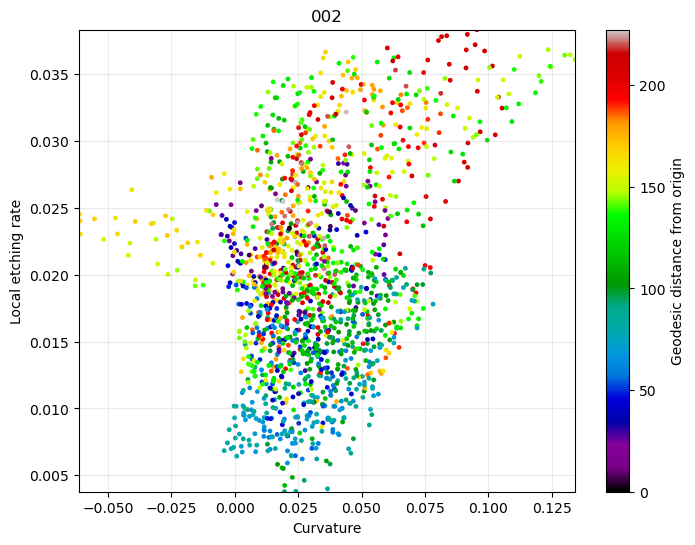

Widget(value='<iframe src="http://localhost:46821/index.html?ui=P_0x70c6b4336c10_3&reconnect=auto" class="pyvi…

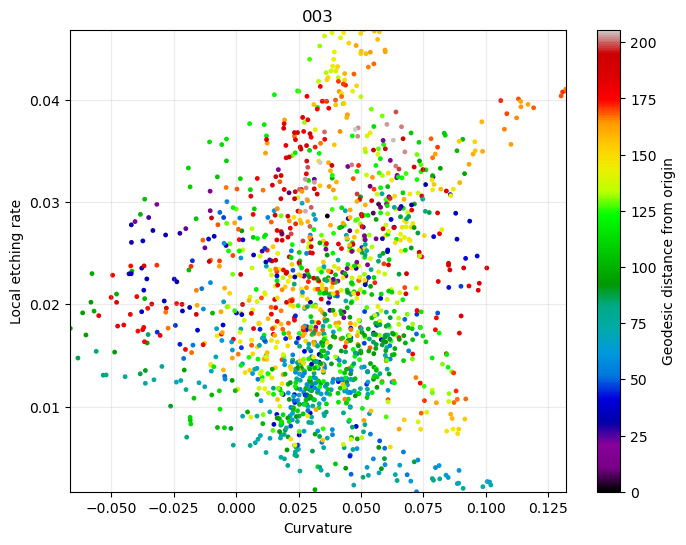

Widget(value='<iframe src="http://localhost:46821/index.html?ui=P_0x70c6b633e990_4&reconnect=auto" class="pyvi…

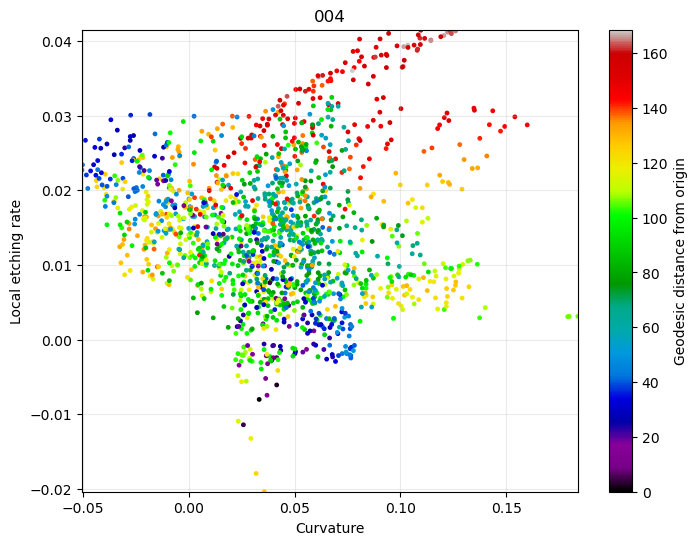

Widget(value='<iframe src="http://localhost:46821/index.html?ui=P_0x70c6a85e4a50_5&reconnect=auto" class="pyvi…

In [6]:
curvature_dir = "surface Cu3As/"
etching_dir = "localEtchingRate_t_t+2/"
model_dir = "surface Cu3As/"

hotspot1 = []
hotspot2 = []

for i in range(5):
    curvature = load_curvature(curvature_dir+"00"+str(int(i))+".am")
    etching_rate = np.loadtxt(etching_dir+"00"+str(int(i))+".csv")
    mesh = pv.read(model_dir+"00"+str(int(i))+".obj").triangulate()
    if i==0:
        origin_index = np.argmax(etching_rate)
        # origin_index = picked_origin["index"]
        origin_point = mesh.points[origin_index]
    else:  # later iterations
    # find closest vertex in this mesh to the original origin_point
        diffs = mesh.points - origin_point
        dists = np.linalg.norm(diffs, axis=1)
        origin_index = np.argmin(dists)
    dist = scatter_plot_with_dist(mesh, curvature, etching_rate, origin_index, title='00'+str(i), show_model=True)
    idx1 = np.argwhere(dist>dist.max()*0.8)
    idx2 = np.argwhere(dist<dist.max()*0.2)
    hotspot1.append([curvature[idx1], etching_rate[idx1]])
    hotspot2.append([curvature[idx2], etching_rate[idx2]])

In [7]:
def overlay_binned_stats_by_Y_width(
    X, Y, bin_width, ax=None, label=None,
    scatter_kwargs=None, point_kwargs=None, err_kwargs=None
):
    """
    Scatter X vs Y, then overlay stats:
      - x-position: mean(X in bin)
      - y-position: median(Y in bin)
      - horizontal error bar: std(X in bin)

    Bin size is controlled by bin_width in Y.
    """
    X = np.asarray(X)
    Y = np.asarray(Y)

    if ax is None:
        fig, ax = plt.subplots()

    # 1) scatter
    # scatter_kwargs = dict(s=10, alpha=0.4) | (scatter_kwargs or {})
    # ax.scatter(X, Y, **scatter_kwargs)

    # 2) make bins based on bin_width
    y_min, y_max = np.nanmin(Y), np.nanmax(Y)
    bins = np.arange(y_min, y_max + bin_width, bin_width)
    bin_idx = np.digitize(Y, bins) - 1
    nb = len(bins) - 1

    # 3) stats
    x_mean   = np.full(nb, np.nan)
    x_std    = np.full(nb, np.nan)
    y_median = np.full(nb, np.nan)

    for b in range(nb):
        mask = (bin_idx == b) & np.isfinite(X) & np.isfinite(Y)
        if not np.any(mask):
            continue
        x_mean[b]   = np.mean(X[mask])
        x_std[b]    = np.std(X[mask], ddof=1)
        y_median[b] = np.median(Y[mask])

    used = np.isfinite(x_mean) & np.isfinite(y_median)
    x_vals = x_mean[used]
    y_vals = y_median[used]
    x_errs = x_std[used]

    point_kwargs = dict(marker='o', mfc='none', mec=(0.32, 0.32, 0.32, 0.3), mew=1.2, ls='none') | (point_kwargs or {})
    err_kwargs   = dict(ecolor=(0.4, 0.4, 0.4), elinewidth=2.0, capsize=3) | (err_kwargs or {})

    ax.errorbar(x_vals, y_vals, xerr=x_errs, yerr=None, label=label, **point_kwargs, **err_kwargs)

    # ax.set_xlabel("X")
    # ax.set_ylabel("Y")
    # ax.set_title(f"Scatter with Y-binned stats (bin width {bin_width})")

    return bins, x_mean, x_std, y_median, used, ax

/tmp/ipykernel_203502/1488666575.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(hotspot1[i][0], hotspot1[i][1], s=10, c=(0.85, 0.85, 0.85))
/tmp/ipykernel_203502/1488666575.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(hotspot2[i][0], hotspot2[i][1], s=10, c=(0.3, 0.3, 0.3))
/home/user/anaconda3/envs/vista/lib/python3.13/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of fr

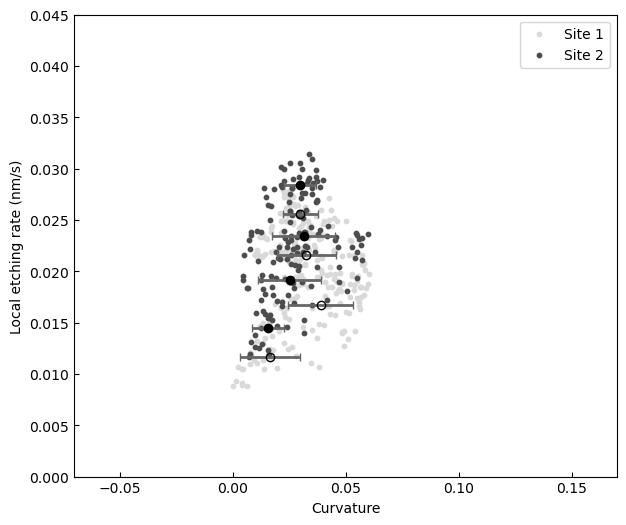

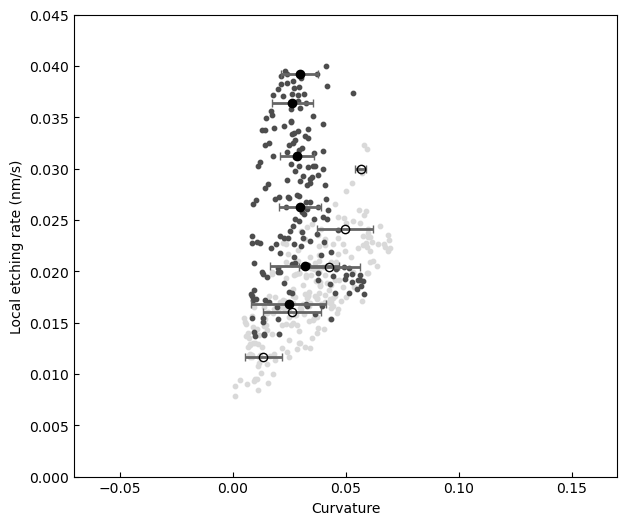

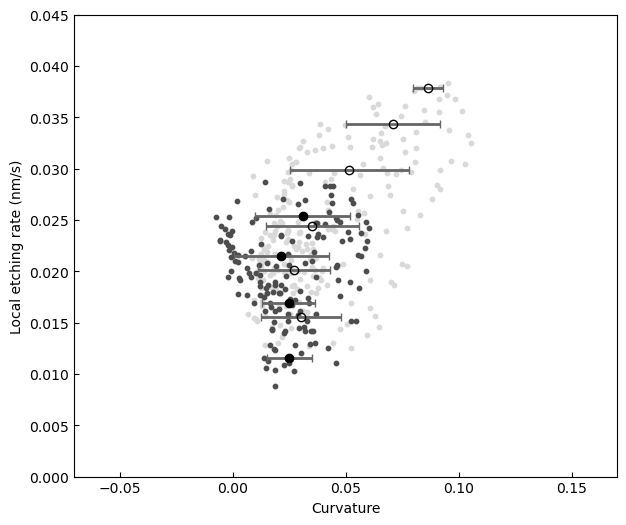

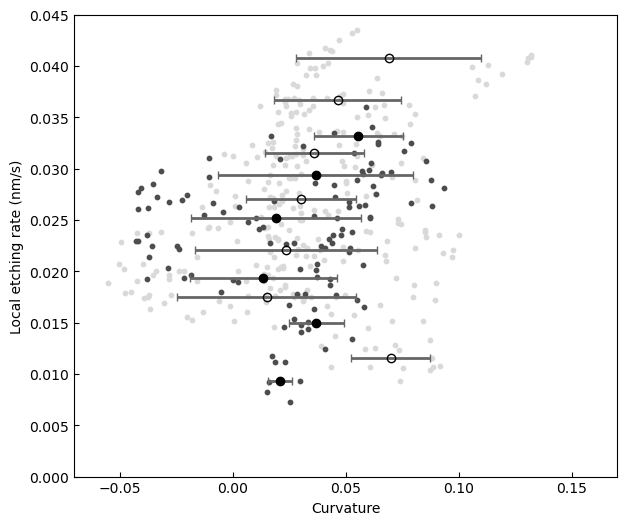

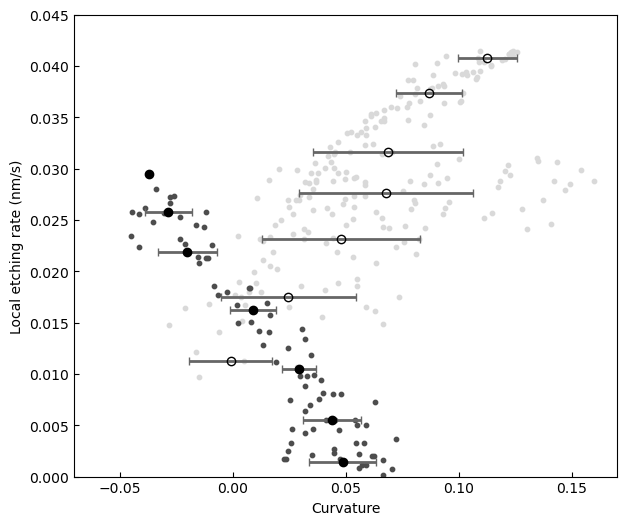

In [8]:
for i in range(5):
    
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.scatter(hotspot1[i][0], hotspot1[i][1], s=10, c=(0.85, 0.85, 0.85))
    ax.scatter(hotspot2[i][0], hotspot2[i][1], s=10, c=(0.3, 0.3, 0.3))
    ax.tick_params(direction="in")
    ax.set_ylim([0, 0.045])
    ax.set_xlim([-0.07, 0.17])
    ax.set_xlabel("Curvature")
    ax.set_ylabel("Local etching rate (nm/s)")
    if i==0:
        ax.legend(["Site 1", "Site 2"])

    _, x_mean1, x_std1, y_median1, _, _ = overlay_binned_stats_by_Y_width(hotspot1[i][0], hotspot1[i][1], 0.005, ax, point_kwargs=dict(marker='o', mfc='none', mec='k', mew=1.0, ls='none'))
    _, x_mean2, x_std2, y_median2, _, _ = overlay_binned_stats_by_Y_width(hotspot2[i][0], hotspot2[i][1], 0.005, ax, point_kwargs=dict(marker='o', mfc='k', mec='k', mew=1.0, ls='none'))

6.8 Characterizing of shape chirality

In [9]:
from pathlib import Path
import tifffile as tiff

In [10]:
def top_fraction_heatmap_for_single_tif(
    input_path,
    top_frac=0.20,          # 20% of the occupied z-extent
    bg_threshold=0.0,       # voxels > bg_threshold are considered "shape"
    mask_background=True,   # zero-out voxels outside the shape before integrating
    normalize=False,        # if True, compute the MEAN across slices instead of SUM
    cmap='viridis',         # any matplotlib colormap string
    out_png_suffix=None     # default filename based on top_frac
):
    """
    For one 3D TIF:
      - Determine shape extent along z via (vol > bg_threshold)
      - Take the TOP 'top_frac' of that z extent (largest z indices)
      - Integrate along z (sum by default, mean if normalize=True)
      - Plot and save a heat map (ny x nx)

    Returns:
      proj: 2D numpy array (ny x nx) of the integrated (or mean) intensity.
      z_slice_info: (z_start, z_end_exclusive, n_slices_used)
    """
    path = Path(input_path)
    vol = tiff.imread(str(path))
    if vol.ndim != 3:
        raise ValueError(f"Expected 3D stack, got shape {vol.shape}")
    ny, nx, nz = vol.shape

    # Build shape mask to detect z-extent
    shape_mask = (vol > bg_threshold)
    yy, xx, zz = np.nonzero(shape_mask)
    if zz.size == 0:
        raise ValueError("Shape mask is empty; try lowering bg_threshold.")

    z0, z1 = int(zz.min()), int(zz.max())
    Lz = z1 - z0 + 1
    k = max(1, math.ceil(top_frac * Lz))        # number of slices (>=1)
    z_start = z1 - k + 1                        # inclusive
    z_end   = z1 + 1                            # exclusive (Python slicing)

    subvol = vol[:, :, z_start:z_end]
    if mask_background:
        submask = shape_mask[:, :, z_start:z_end]
        subvol = np.where(submask, subvol, 0)

    # Integrate along z (axis=2)
    proj = subvol.mean(axis=2) if normalize else subvol.sum(axis=2)

    # Plot heat map
    if out_png_suffix is None:
        out_png_suffix = f"_top{int(round(top_frac*100))}proj.png"
    out_png = path.with_name(path.stem + out_png_suffix)

    plt.figure(figsize=(6, 5.5))
    im = plt.imshow(proj, origin='lower', aspect='equal', cmap=cmap)
    # plt.colorbar(im, fraction=0.046, pad=0.04)
    # plt.title(f"{path.name}  |  z[{z_start}:{z_end}] ({k}/{Lz} slices ≈ {top_frac*100:.1f}%)")
    # plt.xlabel("x (vox)")
    # plt.ylabel("y (vox)")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    # plt.close()
    plt.show()

    print(f"Saved heat map: {out_png}  (z-slices used: {z_start}:{z_end}, count={k})")
    return proj, (z_start, z_end, k)

def _bbox_from_mask2d(mask):
    ys, xs = np.nonzero(mask)
    if ys.size == 0:
        return None
    return int(ys.min()), int(ys.max()), int(xs.min()), int(xs.max())

def _center_crop_to_mask(img, mask):
    """Crop img (and mask) to tight bbox of mask to remove dead background."""
    bb = _bbox_from_mask2d(mask)
    if bb is None:
        return img.copy(), mask.copy()
    y0, y1, x0, x1 = bb
    return img[y0:y1+1, x0:x1+1], mask[y0:y1+1, x0:x1+1]

def _normed_diff(a, b, eps=1e-12):
    """Normalized L1 asymmetry: ||a-b||_1 / ||a+b||_1 ∈ [0,1]."""
    num = np.sum(np.abs(a - b))
    den = np.sum(np.abs(a) + np.abs(b)) + eps
    return float(num / den)

def _pad_to_square(img, pad_value=0.0):
    """Zero-pad 2D array to a square (centered) so diagonal mirrors have same shape."""
    ny, nx = img.shape
    if ny == nx:
        return img
    s = max(ny, nx)
    py_top  = (s - ny) // 2
    py_bot  = s - ny - py_top
    px_left = (s - nx) // 2
    px_right= s - nx - px_left
    return np.pad(img, ((py_top, py_bot), (px_left, px_right)),
                  mode='constant', constant_values=pad_value)

def _rot180(a):
    """Rotate 2D array by 180° about its center (same shape)."""
    return np.rot90(a, 2)

def _c2_overlay(img, mask=None, mask_mode='union'):
    """
    Overlay image with its 180° rotation to stabilize defects.
    Returns (img_c2, mask_c2).
      - img_c2 = 0.5 * (img + rot180(img))
      - mask_c2:
          'union'        -> (mask | rot180(mask))       [default: tolerant to holes]
          'intersection' -> (mask & rot180(mask))       [stricter, drops one-sided outliers]
          None           -> if mask is None, returns None
    """
    J = _rot180(img)
    I_c2 = 0.5 * (img.astype(np.float64) + J.astype(np.float64))
    if mask is None:
        return I_c2, None
    mrot = _rot180(mask.astype(bool))
    if mask_mode == 'intersection':
        M_c2 = mask & mrot
    else:  # 'union' (default) or anything else
        M_c2 = mask | mrot
    return I_c2, M_c2

# ----------------- mirror asymmetry metrics -----------------

def mirror_asymmetry_indices(img, mask=None):
    """
    Normalized L1 asymmetry vs. mirrors across X, Y, main-diagonal, anti-diagonal.
    Returns: dict with A_x, A_y, A_main, A_anti ∈ [0,1].
    """
    I = img.astype(np.float64)

    # Light auto-mask if none provided
    if mask is None:
        mask = I > (0.01 * I.max())

    # Zero background and crop to tight bbox so borders don't bias metrics
    I = np.where(mask, I, 0.0)
    I, _ = _center_crop_to_mask(I, mask)

    # Normalize total intensity
    s = I.sum()
    if s > 0:
        I = I / s

    # Axis mirrors (work fine for rectangles)
    Ix = np.flip(I, axis=1)   # mirror left-right
    Iy = np.flip(I, axis=0)   # mirror up-down
    Ax = _normed_diff(I, Ix)
    Ay = _normed_diff(I, Iy)

    # Diagonal mirrors need square arrays → pad to square first
    I_sq = _pad_to_square(I, pad_value=0.0)
    Imain = I_sq.T                  # main diagonal
    Ianti = np.flip(I_sq.T, axis=1) # anti-diagonal

    Amain = _normed_diff(I_sq, Imain)
    Aanti = _normed_diff(I_sq, Ianti)

    return {"A_x": Ax, "A_y": Ay, "A_main": Amain, "A_anti": Aanti}

# ----------------- signed pseudoscalar “handedness” -----------------

def handedness_pseudoscalar(img, mask=None):
    """
    Signed chirality index H in [-1,1]-ish:
      H = sum( (X * dI/dy - Y * dI/dx) * I ) / sum( r * |∇I| * I )
    where (X,Y) are coords centered at intensity centroid. Flips sign under mirroring.
    """
    I = img.astype(np.float64)
    if mask is None:
        mask = I > (0.01 * I.max())
    I = np.where(mask, I, 0.0)
    I, mask = _center_crop_to_mask(I, mask)
    if I.sum() == 0:
        return np.nan

    # Coordinates relative to intensity centroid
    yy, xx = np.indices(I.shape)
    m = I.sum()
    cx = (xx * I).sum() / m
    cy = (yy * I).sum() / m
    X = xx - cx
    Y = yy - cy

    # Gradients
    dIy, dIx = np.gradient(I)  # note: np.gradient returns (d/dy, d/dx)
    num = np.sum((X * dIy - Y * dIx) * I)
    den = np.sum(np.hypot(X, Y) * np.hypot(dIx, dIy) * I) + 1e-12
    H = num / den
    return float(np.clip(H, -1.0, 1.0))

# ----------------- Hu moments (φ7 flips sign under mirror) -----------------

def hu_moments(img, mask=None):
    """
    Compute Hu's 7 invariants (translation/scale/rotation invariant).
    φ7 changes sign under mirror → good chirality indicator.
    Returns np.array([φ1..φ7]).
    """
    I = img.astype(np.float64)
    if mask is None:
        mask = I > (0.01 * I.max())
    I = np.where(mask, I, 0.0)
    I, mask = _center_crop_to_mask(I, mask)

    yy, xx = np.indices(I.shape)
    m00 = I.sum()
    if m00 == 0:
        return np.full(7, np.nan)

    xbar = (xx * I).sum() / m00
    ybar = (yy * I).sum() / m00
    x = xx - xbar
    y = yy - ybar

    def mu(p, q):
        return float(( (x**p) * (y**q) * I ).sum())

    mu20, mu02, mu11 = mu(2,0), mu(0,2), mu(1,1)
    mu30, mu03 = mu(3,0), mu(0,3)
    mu12, mu21 = mu(1,2), mu(2,1)

    def eta(mu_pq, p, q):
        gamma = (p + q)/2.0 + 1.0
        return mu_pq / (m00 ** gamma)

    e20, e02, e11 = eta(mu20,2,0), eta(mu02,0,2), eta(mu11,1,1)
    e30, e03 = eta(mu30,3,0), eta(mu03,0,3)
    e12, e21 = eta(mu12,1,2), eta(mu21,2,1)

    # Hu invariants
    phi1 = e20 + e02
    phi2 = (e20 - e02)**2 + 4*(e11**2)
    phi3 = (e30 - 3*e12)**2 + (3*e21 - e03)**2
    phi4 = (e30 + e12)**2 + (e21 + e03)**2
    phi5 = ((e30 - 3*e12)*(e30 + e12)*((e30 + e12)**2 - 3*(e21 + e03)**2)
           + (3*e21 - e03)*(e21 + e03)*(3*(e30 + e12)**2 - (e21 + e03)**2))
    phi6 = ((e20 - e02)*((e30 + e12)**2 - (e21 + e03)**2)
           + 4*e11*(e30 + e12)*(e21 + e03))
    phi7 = ((3*e21 - e03)*(e30 + e12)*((e30 + e12)**2 - 3*(e21 + e03)**2)
           - (e30 - 3*e12)*(e21 + e03)*(3*(e30 + e12)**2 - (e21 + e03)**2))
    return np.array([phi1, phi2, phi3, phi4, phi5, phi6, phi7], dtype=float)

def hu_chirality(img, mask=None):
    """
    Signed, log-compressed φ7 (mirroring flips sign):
      C_hu = sign(φ7) * log10(|φ7| + eps)
    """
    phi = hu_moments(img, mask=mask)
    phi7 = phi[-1]
    if not np.isfinite(phi7) or phi7 == 0.0:
        return 0.0
    return float(np.sign(phi7) * np.log10(abs(phi7) + 1e-30))

# ----------------- one-call convenience -----------------

def chirality_metrics(img2d, mask=None):
    """
    Compute a small suite of complementary chirality descriptors for a 2D heat map.
    Returns a dict with:
      - A_x, A_y, A_main, A_anti   (mirror-asymmetry ∈ [0,1])
      - H_pseudo                    (signed handedness ∈ ~[-1,1])
      - HU_phi7, HU_phi7_log       (Hu-moment chirality; sign flips under mirroring)
    """
    A = mirror_asymmetry_indices(img2d, mask=mask)
    H = handedness_pseudoscalar(img2d, mask=mask)
    phi7 = hu_moments(img2d, mask=mask)[-1]
    out = dict(A)
    out["H_pseudo"] = H
    out["HU_phi7"] = float(phi7)
    out["HU_phi7_log"] = hu_chirality(img2d, mask=mask)
    return out

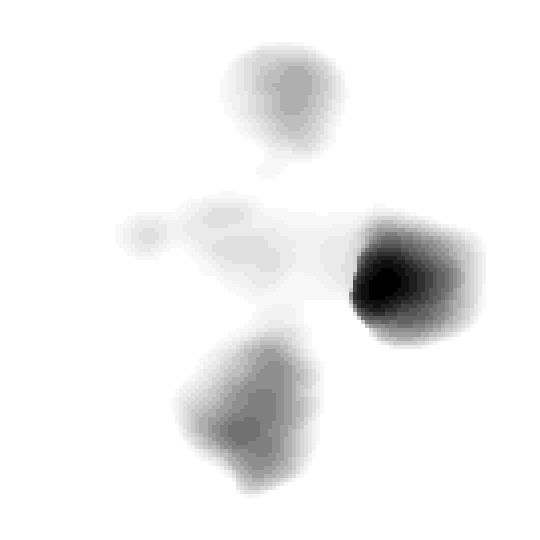

Saved heat map: Chiral Au NP/000.labels_top17proj.png  (z-slices used: 100:119, count=19)


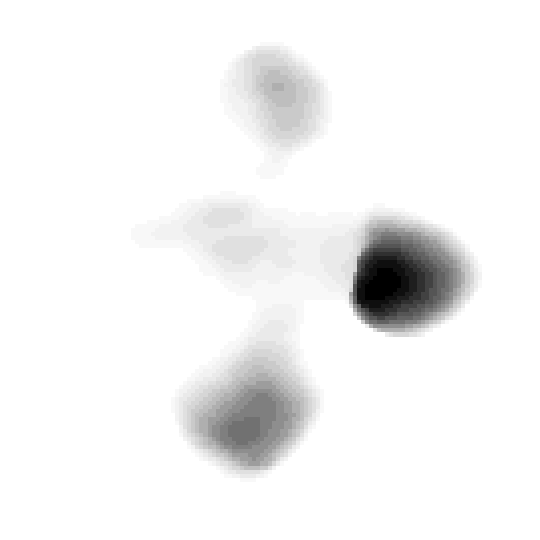

Saved heat map: Chiral Au NP/001.labels_top17proj.png  (z-slices used: 100:119, count=19)


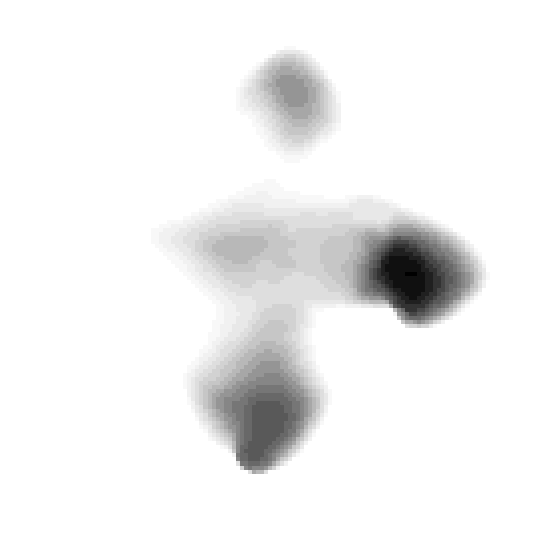

Saved heat map: Chiral Au NP/002.labels_top17proj.png  (z-slices used: 97:115, count=18)


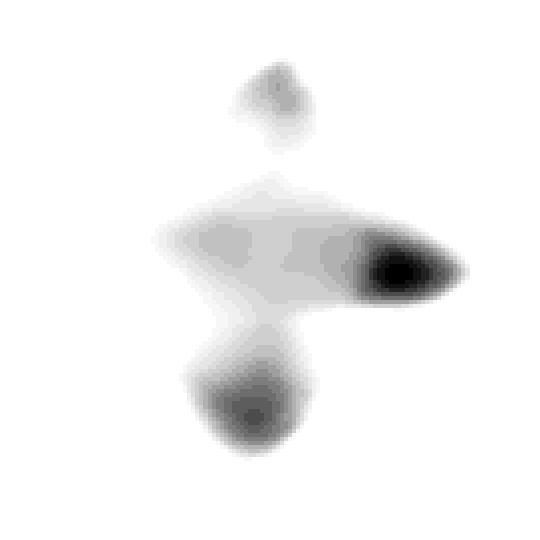

Saved heat map: Chiral Au NP/003.labels_top17proj.png  (z-slices used: 96:113, count=17)


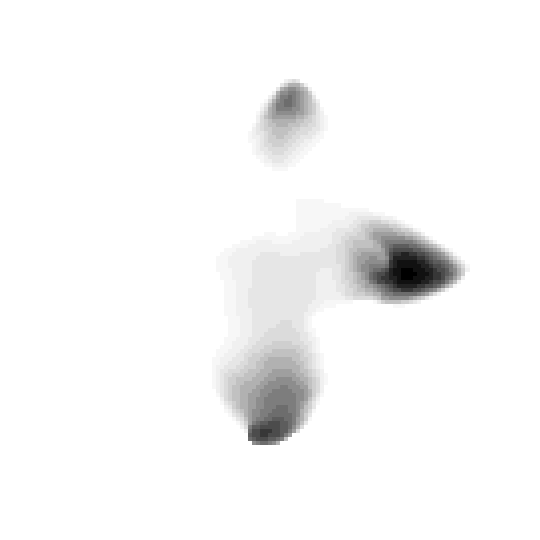

Saved heat map: Chiral Au NP/004.labels_top17proj.png  (z-slices used: 93:110, count=17)


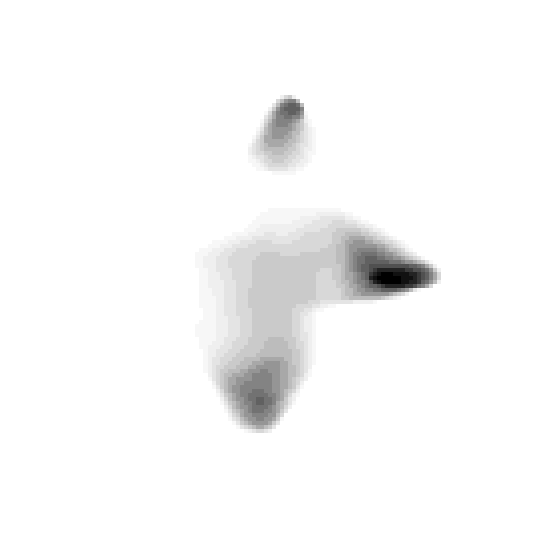

Saved heat map: Chiral Au NP/005.labels_top17proj.png  (z-slices used: 91:107, count=16)


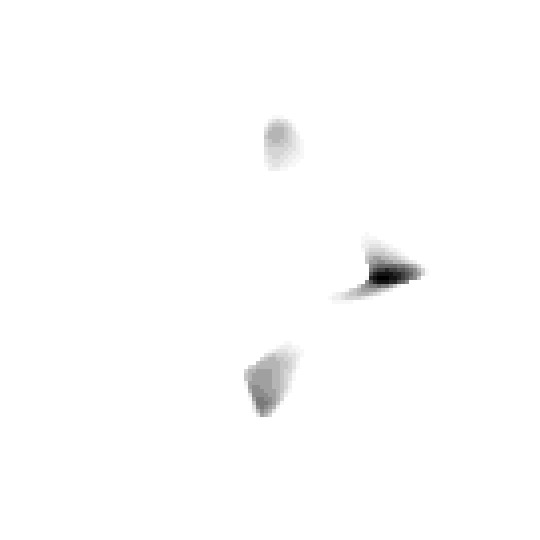

Saved heat map: Chiral Au NP/006.labels_top17proj.png  (z-slices used: 93:108, count=15)


In [11]:
tif_dir = 'Chiral Au NP/' #Binarized 3D tiffs
projs = []
for i in range(7):
    proj, _ = top_fraction_heatmap_for_single_tif(tif_dir+"00"+str(int(i))+".labels.tif", 0.17, cmap='Greys')
    projs.append(proj)

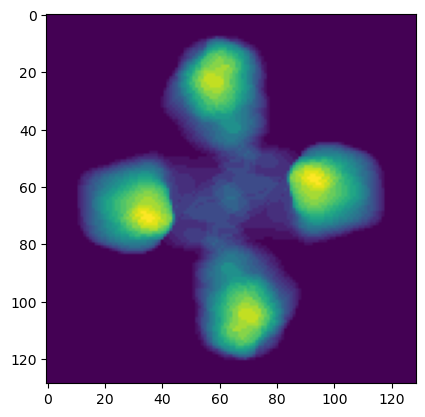

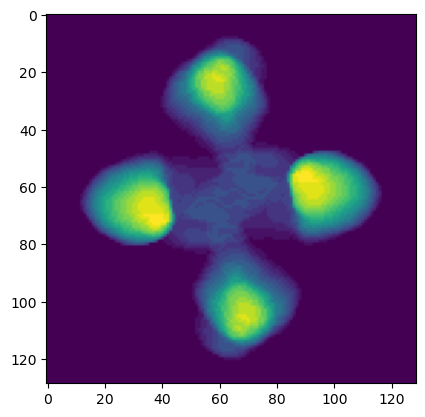

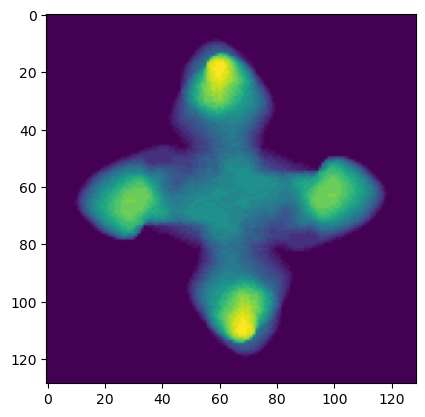

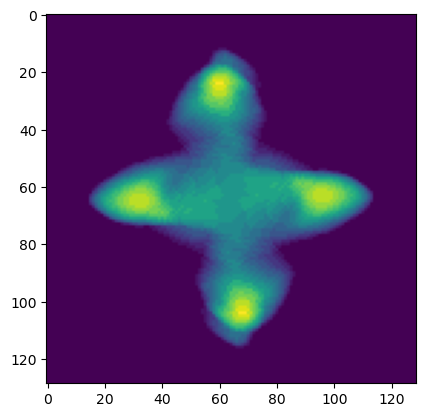

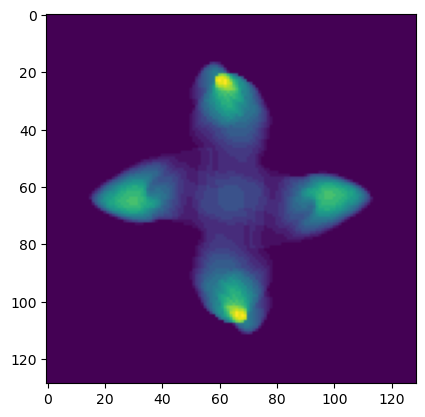

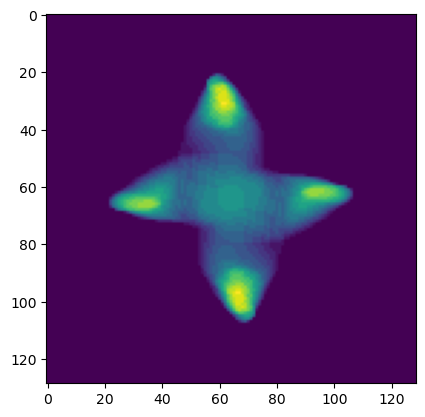

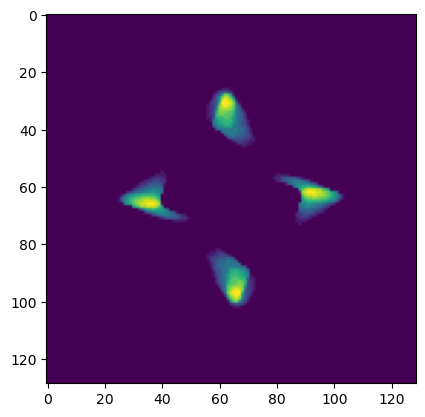

In [12]:
A_xs = []
A_ys = []
A_mains = []
A_antis = []
H_pseudos = []
HU_phi7s= []
for proj in projs:
    mask2d = proj > (0.01 * proj.max())
    proj, mask2d = _c2_overlay(proj, mask=mask2d, mask_mode='intersect')
    plt.figure()
    plt.imshow(proj)
    metrics = chirality_metrics(proj, mask=mask2d)
    A_xs.append(metrics['A_x'])
    A_ys.append(metrics['A_y'])
    A_mains.append(metrics['A_main'])
    A_antis.append(metrics['A_anti'])
    H_pseudos.append(metrics['H_pseudo'])
    HU_phi7s.append(metrics['HU_phi7'])
    # for k, v in metrics.items():
    #     print(f"{k}: {v:.6f}")

A_xs = np.array(A_xs)
A_ys = np.array(A_ys)
A_mains = np.array(A_mains)
A_antis = np.array(A_antis)
H_pseudos = np.array(H_pseudos)
HU_phi7s = np.array(HU_phi7s)

Text(0, 0.5, '$D_{\\sigma}$')

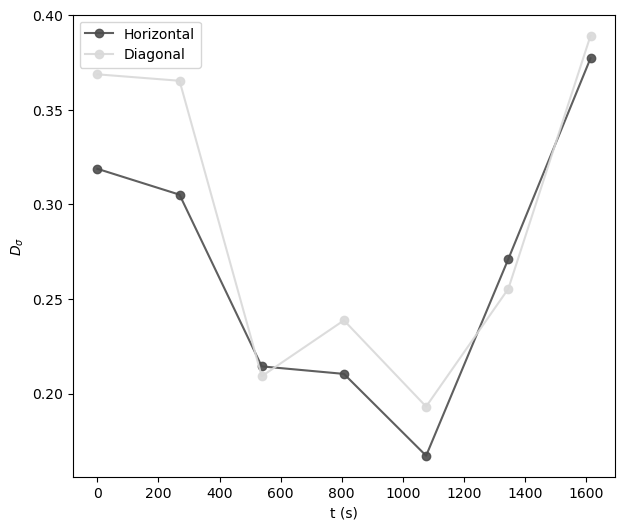

In [13]:
ts = np.linspace(0, 1614, 7)
col = [(0.3, 0.3, 0.3, 0.9), (0.85, 0.85, 0.85, 0.9)]
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(ts, A_xs, color=col[0], marker='o')
ax.plot(ts, A_mains, color=col[1], marker='o')
ax.legend(["Horizontal", "Diagonal"])
ax.set_xlabel("t (s)")
ax.set_ylabel(r"$D_{\sigma}$")